In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm

from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

In [47]:
Carseats = load_data('Carseats')
# If Sales > 8, it's considered high
High = np.where(Carseats.Sales > 9,
                "Yes",
                "No")

In [3]:
# Fitting classification tree
# Begin by creating model matrix
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
# For Annotating Plots
feature_names = list(D.columns)
# Keep copy of data frame as array
X = np.asarray(D)

In [4]:
clf = DTC(criterion='entropy', # whether to use Gini or cross-entropy as split criterion
          max_depth=3,
          random_state=0)
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [5]:
accuracy_score(High, clf.predict(X))

0.8375

In [6]:
# Calculating deviance, lower is better
resid_dev = np.sum(log_loss(High, clf.predict_proba(X)))
resid_dev

0.3553384554444587

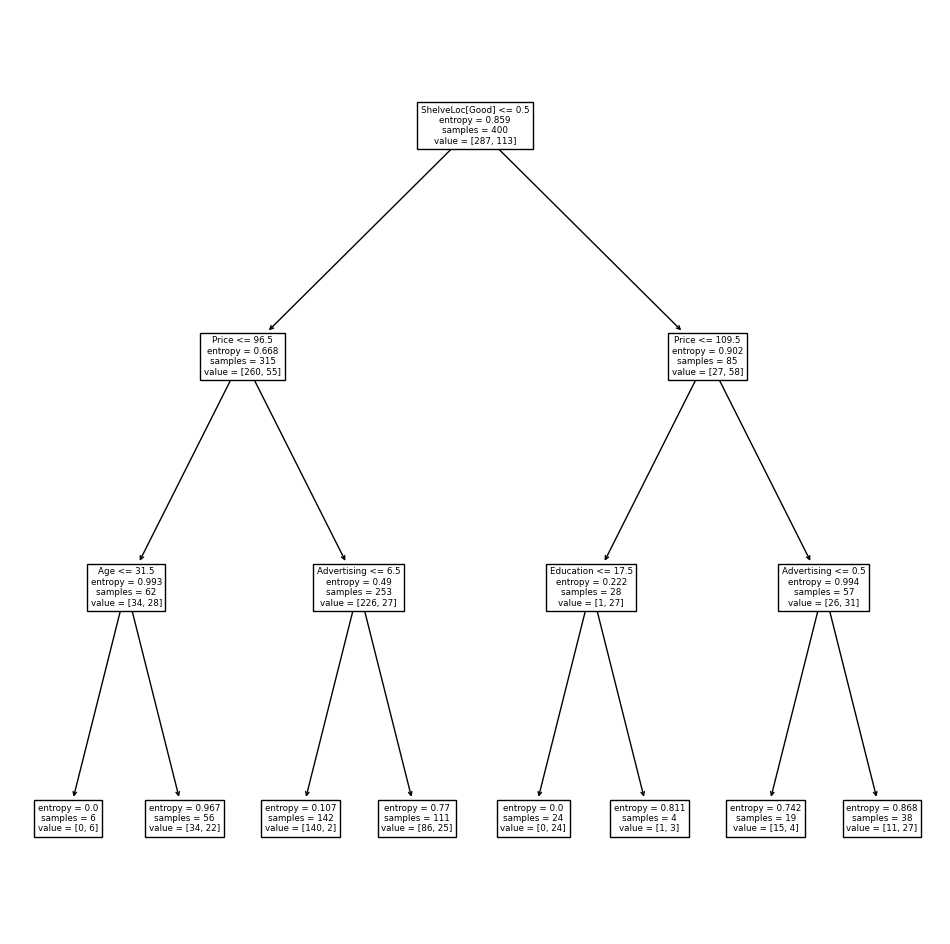

In [7]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

In [8]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 96.50
|   |   |--- Age <= 31.50
|   |   |   |--- weights: [0.00, 6.00] class: Yes
|   |   |--- Age >  31.50
|   |   |   |--- weights: [34.00, 22.00] class: No
|   |--- Price >  96.50
|   |   |--- Advertising <= 6.50
|   |   |   |--- weights: [140.00, 2.00] class: No
|   |   |--- Advertising >  6.50
|   |   |   |--- weights: [86.00, 25.00] class: No
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 109.50
|   |   |--- Education <= 17.50
|   |   |   |--- weights: [0.00, 24.00] class: Yes
|   |   |--- Education >  17.50
|   |   |   |--- weights: [1.00, 3.00] class: Yes
|   |--- Price >  109.50
|   |   |--- Advertising <= 0.50
|   |   |   |--- weights: [15.00, 4.00] class: No
|   |   |--- Advertising >  0.50
|   |   |   |--- weights: [11.00, 27.00] class: Yes



In [9]:
# validation set approach
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=200,
                              random_state=0)
results = skm.cross_validate(clf,
                             D,
                             High,
                             cv=validation)
results['test_score']

array([0.68])

In [10]:
# Splitting dataset for pruning
(X_train,
 X_test,
 High_train,
 High_test) = skm.train_test_split(X,
                                   High,
                                   test_size=0.5,
                                   random_state=0)

In [11]:
# Fit full tree on training set, no max_depth
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.74

In [12]:
# Get the cost-complexity values
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10,  # 10 folds
                  random_state=1,
                  shuffle=True)

In [13]:
# Getting optimal tree via cross-validation
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                         refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.79

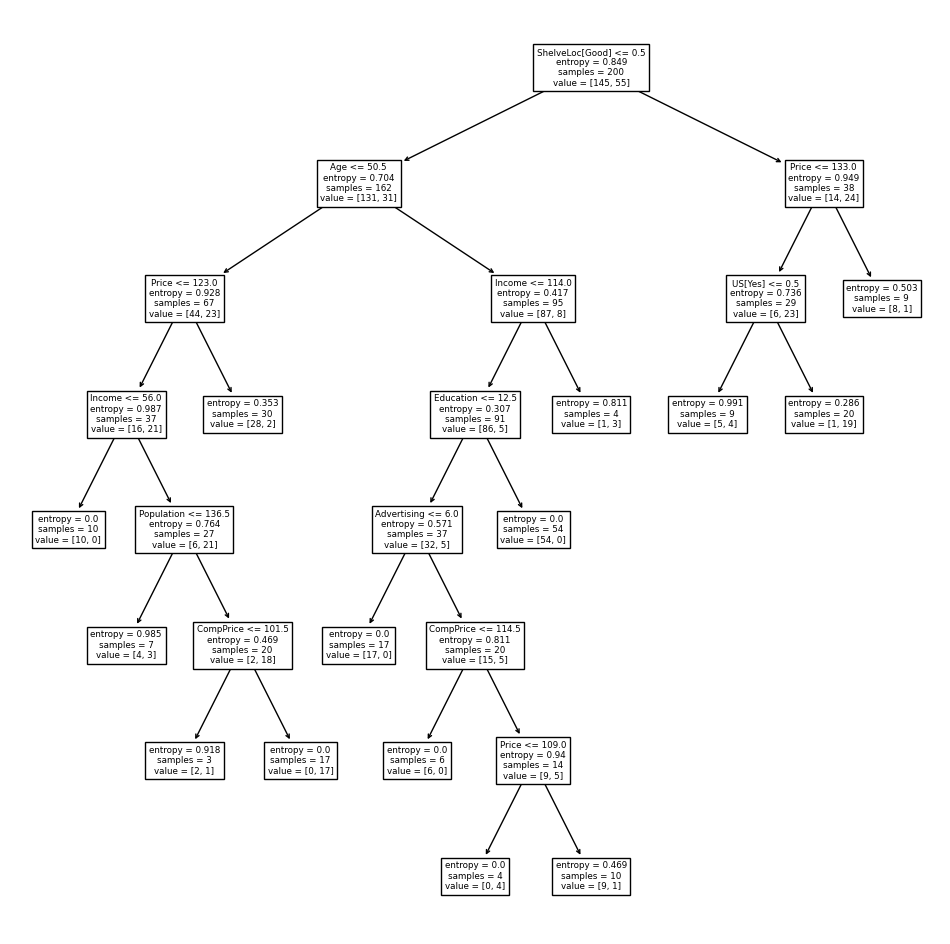

In [14]:
# Plotting pruned tree
ax = subplots(figsize=(12,12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

In [15]:
best_.tree_.n_leaves

14

In [16]:
# Assessing tree on test set
print(accuracy_score(High_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            High_test)
confusion
# Note that this did worse on the test set than the full tree

0.74


Truth,No,Yes
Predicted,,
No,120,30
Yes,22,28


In [17]:
# Initalizing variables
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [18]:
# Split the data
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                     Boston['medv'],
                                     test_size=0.3,
                                     random_state=0)

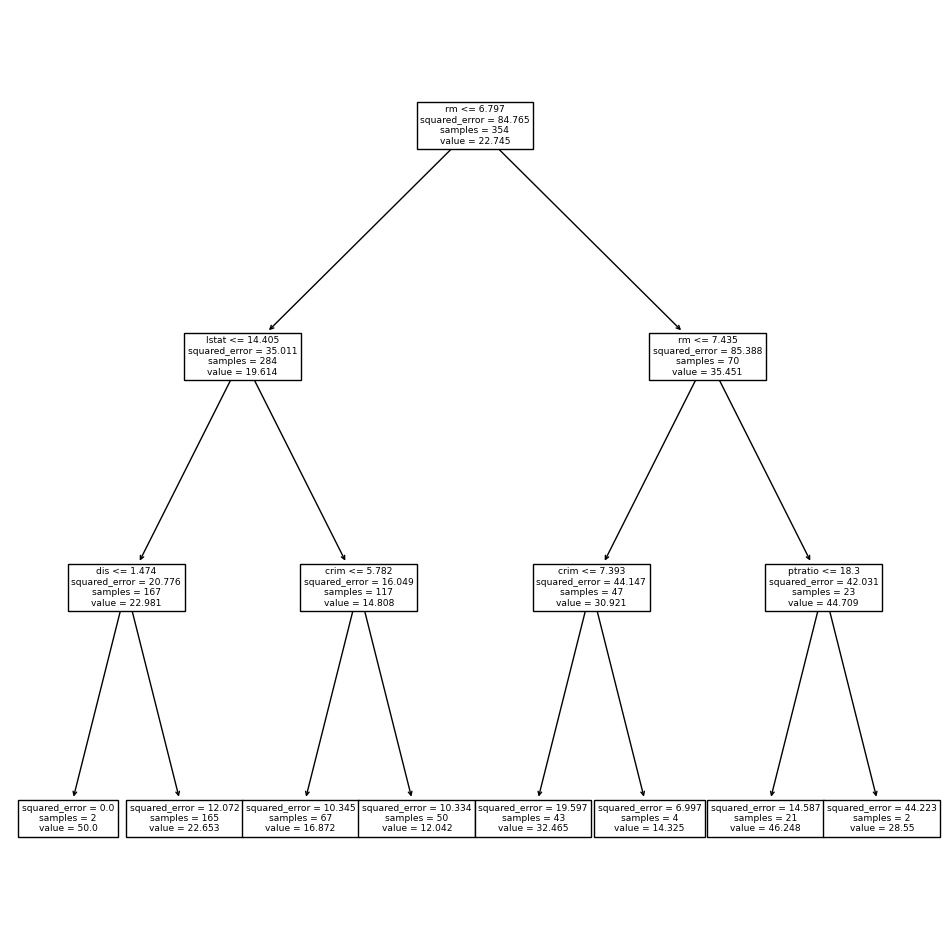

In [19]:
# Fit the regression tree
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [20]:
# Use Cross Validation to prune
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5, shuffle=True, random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [21]:
# Use pruned tree to make predictions on test set
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

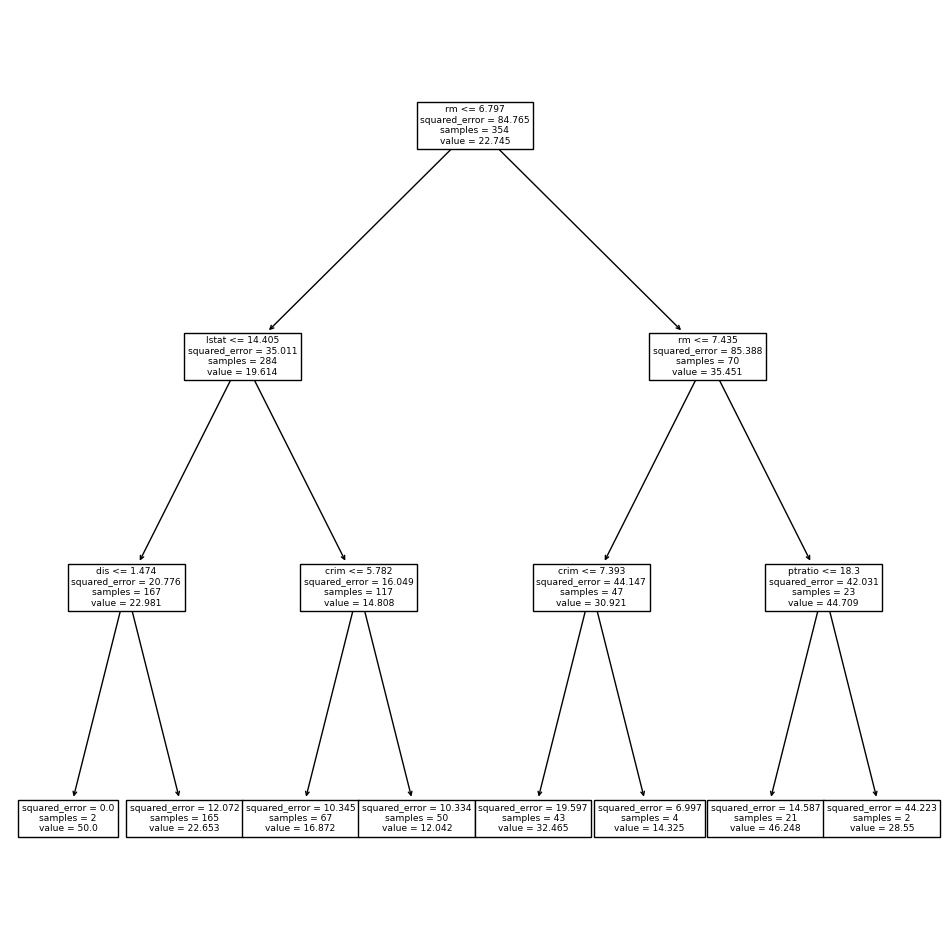

In [22]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);

In [23]:
# Bagging, since max_features = p
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=0)

14.634700151315787

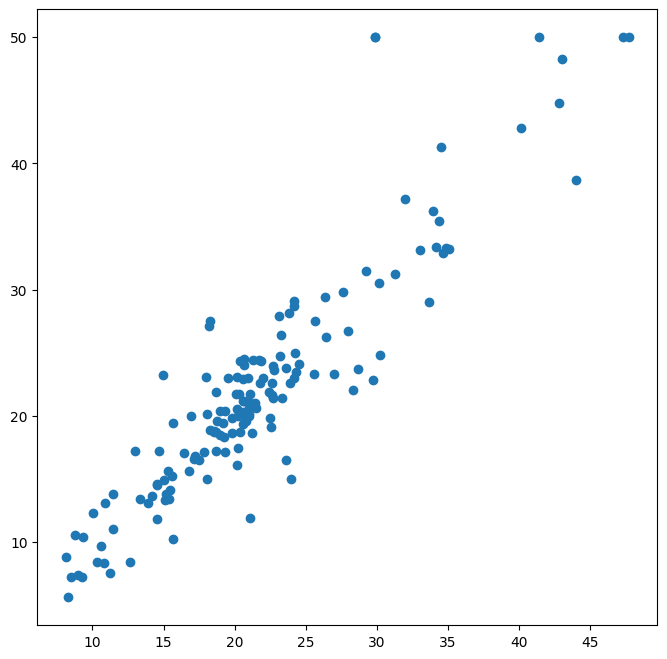

In [24]:
# Evaluate Bagged model's test MSE
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)
np.mean((y_test - y_hat_bag)**2)
# Plot has predicted values on X, and the real values on Y
# Note the MSE is about half pruned tree

In [25]:
# change number of trees grown from default of 100 using n_estimators
bag_boston = RF(max_features=X_train.shape[1],
                n_estimators=500,
                random_state=0).fit(X_train, y_train)
y_hat_bag = bag_boston.predict(X_test)
np.mean((y_test - y_hat_bag)**2)
# Little effect since we can't overfit with higher n_estimator

14.605662565263161

In [26]:
# By default RandomForestRegressor() uses p vars and RandomForestClassifier() uses sqrt(p)
# Random Forest using 6 vars
RF_boston = RF(max_features=6,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
np.mean((y_test - y_hat_RF)**2)
# Note random forests did worse

20.04276446710527

In [27]:
# View importance of each variable
# Creating dataframe to display
feature_imp = pd.DataFrame(
    {'importance': RF_boston.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by ='importance', ascending=False)
# Relative measure of total decrease in node impurity for splits of that specific variable

,importance
lstat,0.356203
rm,0.332163
ptratio,0.067270
crim,0.055404
indus,0.053851
dis,0.041582
nox,0.035225
tax,0.025355
age,0.021506
rad,0.004784


In [28]:
# Boosting
boost_boston = GBR(n_estimators=5000, # number of trees ( best practice to choose by CV)
                   learning_rate=0.001, # dampening factor for each step of model change
                   max_depth=3, # max depth of each tree, chosen kinda arbitrarily
                   random_state=0)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

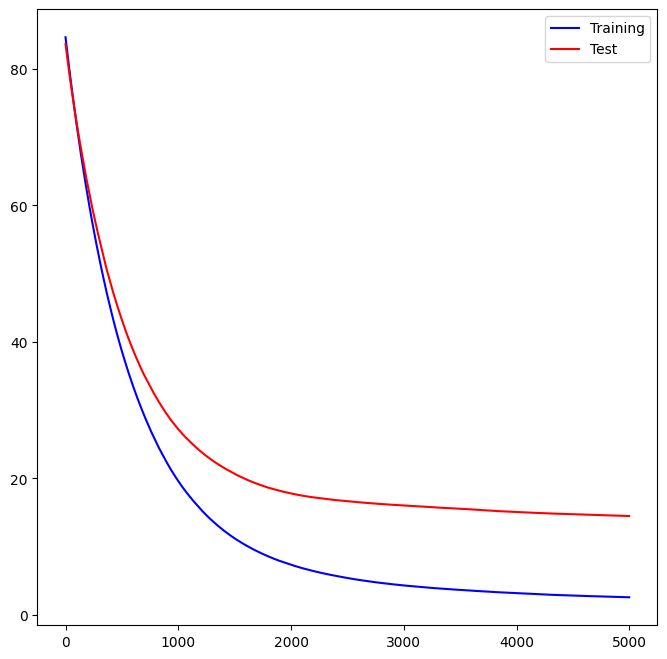

In [29]:
# See test error decreasing
# To be honest this looks useless 
test_error = np.zeros_like(boost_boston.train_score_) # array of 0's with correct shape
# initializing error matrix
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_boston.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [30]:
# Calculating test MSE
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)
# similar to bagging

14.481405918831591

In [31]:
# Using different lambda
boost_boston = GBR(n_estimators=5000, 
                   learning_rate=0.2, 
                   max_depth=3, 
                   random_state=0)
boost_boston.fit(X_train, y_train)
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost)**2)
# Almost same MSE

14.501514553719565

In [32]:
# Bayesian Additive Regression Trees (BART) using ISLP
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [33]:
# Evaluate test MSE
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109225

In [34]:
# Check how many times each var appeared, similar to var importance plot
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0),
                          index = D.columns)
var_inclusion

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64

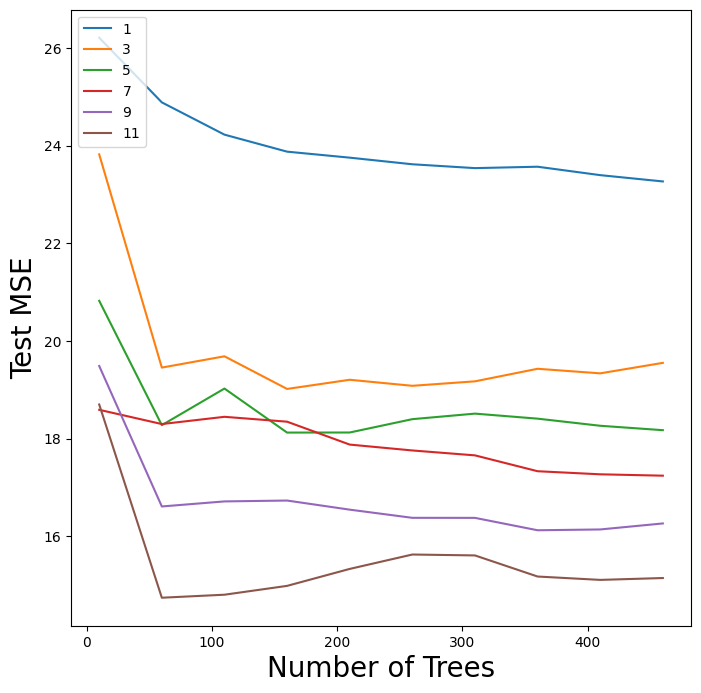

In [45]:
# EXERCISE 7
# Plotting the test MSE for random bagging for a range of estimators and features

MSE_df = pd.DataFrame(np.zeros((10, 6)),
                      columns=range(1,12,2),
                      index=range(10,500,50))
MSE_df.index.name = 'Number of Trees'

for max_features in range(1,12,2):
    test_MSE = []
    for estimators in range(10,500,50):
        bag_boston = RF(max_features=max_features,
                        n_estimators=estimators,
                        random_state=0).fit(X_train, y_train)
        y_hat_bag = bag_boston.predict(X_test)
        test_MSE.append(np.mean((y_test - y_hat_bag)**2))
    MSE_df[max_features] = test_MSE

path_fig, ax = subplots(figsize=(8,8))
MSE_df.plot(ax=ax, legend=False)
ax.set_xlabel('Number of Trees', fontsize=20)
ax.set_ylabel('Test MSE', fontsize=20)
ax.legend(loc='upper left');